In [1]:
import models
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import random
import patsy
from collections import defaultdict

In [2]:
random.seed(20211212)

# MODEL

In [3]:
data = pd.read_csv("explored-diabetes.csv")

## Null model

We first build a baseline null model using the target variable: `glyhb`. Recall from single variable exploratory analysis:

> The [glycosylated hemoglobin](https://en.wikipedia.org/wiki/Glycated_hemoglobin), a diagnostic test often referred to as simply a "hemoglobin A1c", is measured primarily to determine the three-month average blood sugar level.

The hemoglobin A1c works as a quasi-classification variable, with a diagnosis for the following ranges:

| A1c        | diagnosis   |
|------------|-------------|
| < 5.7%     | normal      | 
| 5.7 - 6.4% | prediabetic |
| > 6.4%     | diabetic    |

In [4]:
data["glyhb"].describe()

count    390.000000
mean       5.589769
std        2.242595
min        2.680000
25%        4.380000
50%        4.840000
75%        5.600000
max       16.110001
Name: glyhb, dtype: float64

Let's collect the null model's information: the mean and standard deviation or our target variable A1c.

In [5]:
null_mean = data["glyhb"].describe()["mean"]
null_mean

5.589769236246667

In [6]:
null_std = data["glyhb"].describe()["std"]
null_std

2.242594841991535

The mean for the target variable is 5.5898%, with a standard deviation or equivalent $\sigma$ of 2.2426%. Our goal is to improve upon this naive model using our linear regression model.

## Linear regression model

We begin first with the "all in" linear regression model. First, we'll have to rename a few columns due to specifics with our modeling library not accepting variables with periods.

In [7]:
data.rename(columns={"stab.glu": "stab_glu", "time.ppn": "time_ppn", "bp.s": "bp_s", "bp.d": "bp_d"}, inplace=True)

Next, we'll one-hot encode the `gender` and `frame` variables for potential use in our linear model.

In [8]:
data = data.join(pd.get_dummies(data["gender"]))
data = data.join(pd.get_dummies(data["frame"]))

Our "all in" linear regression model will consist of all available numeric (non-categorical) variables, exluding a few: `glyhb`, `eAG`, `female`, and `small`. The first two as they are either the target variable itself, or a analog of the target variable. The latter two are redundant variables --  a side effect of the one-hot encoding -- that are already expressed as the intercepts of the variables.

In [9]:
subset = data.select_dtypes(include="number").columns.drop(["glyhb", "female", "small", "eAG"])
model = f'glyhb ~ {" + ".join(subset)}'
result1 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-8.40,-28.80,9.90
chol,$\beta_{1}$,0.00,-0.00,0.01
stab_glu,$\beta_{2}$,0.03,0.02,0.03
hdl,$\beta_{3}$,0.00,-0.03,0.02
ratio,$\beta_{4}$,0.12,-0.23,0.36
age,$\beta_{5}$,0.01,0.00,0.02
height,$\beta_{6}$,0.07,-0.15,0.24
weight,$\beta_{7}$,-0.01,-0.04,0.02
waist,$\beta_{8}$,-0.05,-0.43,0.38


We can learn a lot from the initial model -- first, the overall performance is fairly decent.

- Somewhat surprising, the model seems to have found a relationship between waist-to-hip ratio and A1c. This counters our exploratory data analysis, but falls inline with other diabetes prediction models.
- Stabilized glucose is a positive relationship -- as it increases, so does A1c (diabetes more likely). However, this relationship was strong, but due to the inconsistent scales, the "importance" of this variable may be understated in the model.
- BMI is supported in the data, but is victim to the same scale issue as stabilized glucose.
- There are several variables expressed multiple times, such as `hip` and `waist` being redundant with `waist_hip` there.
- Frame shows a relationship, but is inconsistent across the "large" and "medium" categories.

Before we proceed, let's look at correlation coeffecients for each of our numeric variables:

In [10]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [11]:
correlations(data.dropna(), "glyhb", data.select_dtypes(include="number").columns)

,feature,r,rho
0,chol,0.271652,0.225731
1,stab_glu,0.740905,0.519988
2,hdl,-0.169496,-0.210278
3,ratio,0.354653,0.309827
4,glyhb,1.000000,1.000000
5,age,0.332230,0.427119
6,height,0.052251,0.025864
7,weight,0.167769,0.222719
8,waist,0.247687,0.333495
9,hip,0.151673,0.234254


This confirms a lot of what we saw in our initial model. Stabilized glucose shows the strongest positive relationship -- nothing unexpected there. Cholesterol ratio shows the strongest relationship amonst the cholesterol-related variables. The waist-to-hip relationship is certainly present, most variables with relationships deomonstrating possibly non-linear relationship based on the Spearman's coeffecients.

Let's simplify our model using only variables with relationships to the target variable:

In [12]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age"]
model = f'glyhb ~ {" + ".join(subset)}'
result2 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.41,-1.09,2.30
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.00,0.26
waist_hip,$\beta_{3}$,0.60,-1.38,2.72
large,$\beta_{4}$,-0.08,-0.51,0.37
medium,$\beta_{5}$,0.17,-0.16,0.53
bmi,$\beta_{6}$,0.01,-0.02,0.03
age,$\beta_{7}$,0.02,0.01,0.02
,,,,


Good, our $R^2$ and $\sigma$ are mantained despite the reduction in variables. Next, we'll use domain knowledge to bolster our model. Let's define one-hot encoded boolean variables discussed in exploratory data analysis: whether the individual is `obese`, whether the individual is `older`, and whether the individual has `hypertension`. We'll also attempt to use the stabilized glucose value as an indicator as to whether the indiviual is `diabetic`.

In [13]:
data["obese"] = (data["bmi"] > 30).astype(int, errors="ignore")
data["older"] = (data["age"] > 60).astype(int, errors="ignore")
data["hypertension"] = ((data["bp_s"] < 130) & (data["bp_d"] < 80)).astype(int, errors="ignore")
data["diabetic"] = (data["stab_glu"] > 130).astype(int, errors="ignore")

Let's add these to see if there is any effect on the overall performance of the linear model:

In [14]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age", "obese", "older", "hypertension"]
model = f'glyhb ~ {" + ".join(subset)}'
result3 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-0.06,-2.17,1.44
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.01,0.25
waist_hip,$\beta_{3}$,0.63,-1.12,2.81
large,$\beta_{4}$,-0.09,-0.55,0.28
medium,$\beta_{5}$,0.17,-0.15,0.55
bmi,$\beta_{6}$,0.03,0.00,0.07
age,$\beta_{7}$,0.02,0.00,0.03
obese,$\beta_{8}$,-0.39,-0.82,0.03


Not enough of a difference to make it worth including them. Let's finalize our model:

In [15]:
subset = ["stab_glu", "ratio", "waist_hip", "large", "medium", "bmi", "age"]
model =f'glyhb ~ {" + ".join(subset)}'
result4 = models.bootstrap_linear_regression(model, data=data.dropna(subset=subset))
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.41,-1.88,2.15
stab_glu,$\beta_{1}$,0.03,0.02,0.03
ratio,$\beta_{2}$,0.15,-0.02,0.25
waist_hip,$\beta_{3}$,0.60,-1.27,2.93
large,$\beta_{4}$,-0.08,-0.50,0.36
medium,$\beta_{5}$,0.17,-0.19,0.51
bmi,$\beta_{6}$,0.01,-0.02,0.03
age,$\beta_{7}$,0.02,0.01,0.03
,,,,


Next, we'll look at the residuals to determine any further transformations:

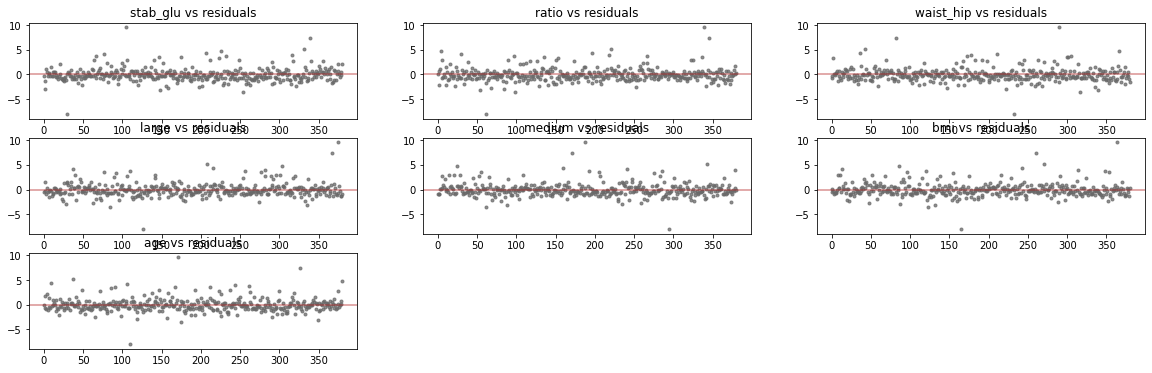

In [16]:
figure = plt.figure(figsize=(20,6))
variables = subset
plots = len(variables)
rows = (plots // 3) + 1

for i, variable in enumerate(variables): 
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip(data[variable].values, result4["residuals"]), key=lambda x: x[0])
    residuals = [x[1][0] for x in keyed_values]
    axes.plot(list(range(0, result4["n"])), residuals, ".", color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result4["n"], c="firebrick", alpha=0.5)
    axes.set_title(variable + " vs residuals")

plt.show()
plt.close()

Wow -- these all look phenomenal. The residuals seem to indicate incredibly linear relationships across the board, thus no further transformation would be very beneficial.

## Evaluation / comparison

In [17]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [18]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [19]:
cv_result = cross_validation(models.linear_regression, model, data, lambda r: (r["sigma"], r["r_squared"]))

In [20]:
print("95% CI for σ:", stats.mstats.mquantiles([r[0] for r in cv_result], [0.025, 0.975]))

95% CI for σ: [0.92094405 2.57516703]


In [21]:
print("95% CI for R²:", stats.mstats.mquantiles([r[1] for r in cv_result], [0.025, 0.975]))

95% CI for R²: [-0.16736561  0.81240313]


In [22]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [23]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)

                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

In [24]:
lc_results = learning_curves(models.linear_regression, model, data, lambda r: r["sigma"])

/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analysis/models.py:42: RuntimeWarning: invalid value encountered in sqrt
  result["sigma"] = np.sqrt( sum_squared_error / (n - k))
/Users/gagebenne/Projects/data-science/diabetes-data-analy

In [25]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [26]:
def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)
    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    axes.legend()
    axes.set_xlabel("training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")
    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()

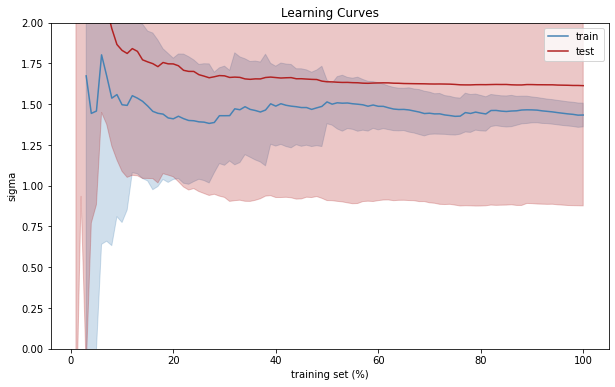

In [27]:
plot_learning_curves(lc_results, "sigma", zoom=True)